In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import matplotlib 

matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = "12"
plt.rcParams['figure.figsize'] = (16 , 5)
plt.rcParams['font.family'] = "NanumGothic"
warnings.filterwarnings('ignore')

In [2]:
import optuna
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression , Ridge , Lasso , ElasticNet
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler

from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder

In [3]:
def rmse(y_test, y_pred):
    result = mse(y_test , y_pred) ** 0.5
    return result

In [4]:
TRAIN = pd.read_csv('train_data.csv')
TEST = pd.read_csv('test_data.csv')

train = TRAIN.copy()
test  = TEST.copy()

In [5]:
MACHINE_NO_mapper = train.groupby('MACHINE_NO')['OUT'].agg(['mean' ,'std'   , 'skew'])
EQUIP1_mapper = train.groupby('EQUIP1')['OUT'].agg(['mean' ,'std'   , 'skew'])
EQUIP2_mapper = train.groupby('EQUIP2')['OUT'].agg(['mean' ,'std'   , 'skew'])
EQUIP3_mapper = train.groupby('EQUIP3')['OUT'].agg(['mean' ,'std'   , 'skew'])
EQUIP3_mapper[EQUIP3_mapper.isnull()] = 0 
EQUIP4_mapper = train.groupby('EQUIP4')['OUT'].agg(['mean' ,'std'   , 'skew'])

In [6]:
( MACHINE_NO_mapper.isnull().sum().sum() , EQUIP1_mapper.isnull().sum().sum() , EQUIP2_mapper.isnull().sum().sum()  , 
    EQUIP3_mapper.isnull().sum().sum() ,EQUIP4_mapper.isnull().sum().sum())

(0, 0, 0, 0, 0)

In [7]:
train_desc = pd.DataFrame()
test_desc = pd.DataFrame()
for list_i in [ 'std' , 'skew']:
    train_desc[f'MACHINE_NO_{list_i}'] = train['MACHINE_NO'].map(dict(MACHINE_NO_mapper[list_i]))
    train_desc[f'EQUIP1_{list_i}'] = train['EQUIP1'].map(dict(EQUIP1_mapper[list_i]))
    train_desc[f'EQUIP2_{list_i}'] = train['EQUIP2'].map(dict(EQUIP2_mapper[list_i]))
    train_desc[f'EQUIP3_{list_i}'] = train['EQUIP3'].map(dict(EQUIP3_mapper[list_i]))
    train_desc[f'EQUIP4_{list_i}'] = train['EQUIP4'].map(dict(EQUIP4_mapper[list_i]))
    
    test_desc[f'MACHINE_NO_{list_i}'] = test['MACHINE_NO'].map(dict(MACHINE_NO_mapper[list_i]))
    test_desc[f'EQUIP1_{list_i}'] = test['EQUIP1'].map(dict(EQUIP1_mapper[list_i]))
    test_desc[f'EQUIP2_{list_i}'] = test['EQUIP2'].map(dict(EQUIP2_mapper[list_i]))
    test_desc[f'EQUIP3_{list_i}'] = test['EQUIP3'].map(dict(EQUIP3_mapper[list_i]))
    test_desc[f'EQUIP4_{list_i}'] = test['EQUIP4'].map(dict(EQUIP4_mapper[list_i]))

In [8]:
train_desc.shape , test_desc.shape

((69933, 10), (17484, 10))

In [9]:
train['MACHINE_NO'] = train['MACHINE_NO'].map(dict(MACHINE_NO_mapper['mean']))
train['EQUIP1'] = train['EQUIP1'].map(dict(EQUIP1_mapper['mean']))
train['EQUIP2'] = train['EQUIP2'].map(dict(EQUIP2_mapper['mean']))
train['EQUIP3'] = train['EQUIP3'].map(dict(EQUIP3_mapper['mean']))
train['EQUIP4'] = train['EQUIP4'].map(dict(EQUIP4_mapper['mean']))

In [10]:
test['MACHINE_NO'] = test['MACHINE_NO'].map(dict(MACHINE_NO_mapper['mean']))
test['EQUIP1'] = test['EQUIP1'].map(dict(EQUIP1_mapper['mean']))
test['EQUIP2'] = test['EQUIP2'].map(dict(EQUIP2_mapper['mean']))
test['EQUIP3'] = test['EQUIP3'].map(dict(EQUIP3_mapper['mean']))
test['EQUIP4'] = test['EQUIP4'].map(dict(EQUIP4_mapper['mean']))

In [11]:
X = train.drop('OUT' , axis = 1)
y = train['OUT']

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['VAL1' , 'VAL2']])
X[['VAL1' , 'VAL2']] = X_scaled

In [13]:
poly_features = PolynomialFeatures(degree=3, include_bias=False ) # 기본 다항식형태를 만들고
X_poly = poly_features.fit_transform(X)
poly_columns = poly_features.get_feature_names(X.columns)
X_poly = pd.DataFrame(X_poly ,columns =  poly_columns)

In [14]:
X_poly.shape , y.shape

((69933, 119), (69933,))

In [15]:
X_poly = pd.concat([X_poly , train_desc] , axis = 1)
feature_columns = X_poly.columns 
X.shape  , X_poly.shape

((69933, 7), (69933, 129))

In [16]:
test_scaled_ = scaler.transform(test[['VAL1' , 'VAL2']])
test[['VAL1' , 'VAL2']] = test_scaled_
test_poly = poly_features.transform(test)
test_poly_ = pd.DataFrame(test_poly ,columns =  poly_columns)
test_poly = pd.concat([test_poly_,test_desc], axis = 1)

In [17]:
model = CatBoostRegressor(learning_rate = 0.2 , random_state=42 , verbose = 0 )

In [18]:
X_train , X_val  , y_train , y_val = train_test_split(X_poly , y , train_size = 0.8 , random_state = 42)

In [19]:
model.fit(X_train , y_train ,verbose=0)

In [20]:
y_pred = model.predict(X_train)
mse(y_pred , y_train) ** 0.5

0.12685836582602655

In [21]:
y_pred = model.predict(X_val)
mse(y_pred , y_val) ** 0.5

0.20681601677488354

In [22]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

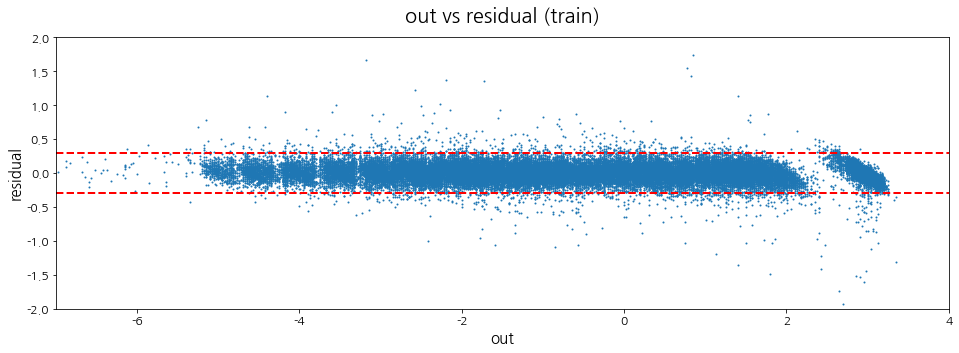

In [23]:
plt.scatter(y_train, ((train_pred - y_train)), s = 1)
plt.xlim([-7, 4])
plt.ylim([-2, 2])
plt.axhline(0.2, 0, 1, color='red', linestyle='--', linewidth=2)
plt.axhline(-0.2, 0, 1, color='red', linestyle='--', linewidth=2)
plt.title('out vs residual (train)', pad = 15, size = 20)
plt.xlabel('out', size = 15)
plt.ylabel('residual', size = 15)
plt.show()

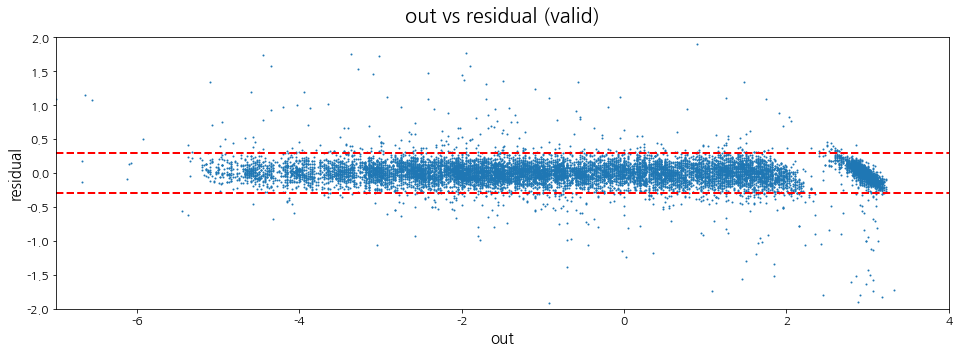

In [24]:
plt.scatter(y_val, ((val_pred - y_val)), s = 1)
plt.xlim([-7, 4])
plt.ylim([-2, 2])
plt.axhline(0.2, 0, 1, color='red', linestyle='--', linewidth=2)
plt.axhline(-0.2, 0, 1, color='red', linestyle='--', linewidth=2)
plt.title('out vs residual (valid)', pad = 15, size = 20)
plt.xlabel('out', size = 15)
plt.ylabel('residual', size = 15)
plt.show()

In [29]:
cut = 0.2
n_copy = 4

In [30]:
temp_train = X_train.copy()
temp_train['y'] = y_train.tolist()
temp_train['type'] = (abs(y_train - train_pred) > cut).astype(int).tolist()
temp_train_1 = temp_train[temp_train['type'] == 1][list(temp_train)[:-1]]

In [31]:
temp_X = np.concatenate((np.array(X_train), np.tile(np.array(temp_train_1.drop(['y'], axis = 1)),reps = [n_copy,1])), axis = 0)
temp_y = y_train.tolist() + temp_train_1['y'].tolist()*n_copy

In [32]:
weights = [0.1*i for i in range(11)]
history_1 = pd.DataFrame()
history_1['weight'] = []
history_1['score'] = []
model_1 = CatBoostRegressor(learning_rate = 0.2 , random_state=42 , verbose = 0 )
model_1.fit(temp_X, temp_y ,verbose=0)
val_pred_1 = model_1.predict(X_val)
idx = 0

for weight in weights:
    val_pred = [x*weight+y*(1-weight) for x,y in zip(val_pred_0, val_pred_1)]
    score = mse(val_pred , y_val) ** 0.5
    history_1.loc[idx] = [weight, score]
    idx += 1

In [33]:
history_1.sort_values(['score'])

,weight,score
5,0.5,0.200313
6,0.6,0.200565
4,0.4,0.200594
7,0.7,0.201350
3,0.3,0.201408
8,0.8,0.202661
2,0.2,0.202747
9,0.9,0.204487
1,0.1,0.204601
10,1.0,0.206816


In [34]:
cut = 0.2
n_copy = 4
weight = 0.5

In [35]:
augmentation_train = X_train.copy()
augmentation_train['y'] = y_train.tolist()
augmentation_train['type'] = (abs(y_train - train_pred) > cut).astype(int).tolist()
augmentation_train_1 = augmentation_train[augmentation_train['type'] == 1][list(augmentation_train)[:-1]]

In [36]:
augmentation_X = np.concatenate((np.array(X_poly), np.tile(np.array(augmentation_train_1.drop(['y'], axis = 1)),reps = [n_copy,1])), axis = 0)
augmentation_y = y.tolist() + augmentation_train_1['y'].tolist()*n_copy

In [37]:
augmentation_X = pd.DataFrame(augmentation_X , columns = X_poly.columns)
augmentation_y = pd.DataFrame(augmentation_y , columns = ['OUT'])

In [26]:
def objective_0(trial):
    GPU_type = True
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 5000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 0.4),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,10),
        'random_strength': trial.suggest_uniform('random_strength',1,10),
        'depth': trial.suggest_int('depth',6, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,5),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose' : 0 ,
        'loss_function' : 'RMSE' , 
        'random_state' : 42 ,
        'task_type' : 'GPU' , 
        'bootstrap_type' : 'Poisson'
        
    }
    kf = KFold(n_splits= 5 , shuffle= True , random_state = 42  )
    result = []
    model_0 = CatBoostRegressor(**params   )
    for folder_counter , (train_idx , val_idx) in enumerate(kf.split(X_poly, y)):
#         print(folder_counter)
        X_train = X_poly.iloc[train_idx ,:]
        X_val = X_poly.iloc[val_idx , :]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx ]
#         print('start' , X_train.shape , y_train.shape , X_val.shape , y_val.shape )
        model_0.fit(X_train , y_train , eval_set= (X_val , y_val), early_stopping_rounds=10)
#         print('end')
        y_pred = model_0.predict(X_val)
        result.append(  rmse(y_pred , y_val))
    return np.array(result).mean()


In [27]:
'''
study_0 = optuna.create_study(direction="minimize" )
study_0.optimize(objective_0, n_trials=50, timeout=600 )
'''

[I 2022-03-27 06:50:47,594] A new study created in memory with name: no-name-d09ada01-f6fe-4609-9f2e-c6368fe3326b
[I 2022-03-27 06:50:56,557] Trial 0 finished with value: 0.22981272134826364 and parameters: {'iterations': 3575, 'od_wait': 772, 'learning_rate': 0.3076272530208006, 'reg_lambda': 6.340607140185167, 'random_strength': 3.8743051291564217, 'depth': 6, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 9}. Best is trial 0 with value: 0.22981272134826364.
[I 2022-03-27 06:51:32,705] Trial 1 finished with value: 0.20453449486744132 and parameters: {'iterations': 1997, 'od_wait': 549, 'learning_rate': 0.11255972854133497, 'reg_lambda': 0.9401116269927552, 'random_strength': 7.105152672756906, 'depth': 9, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 9}. Best is trial 1 with value: 0.20453449486744132.
[I 2022-03-27 06:51:48,464] Trial 2 finished with value: 0.21759158426818398 and parameters: {'iterations': 3805, 'od_wait': 1984, 'learning_rate': 0.23185865076904671, 'r

In [28]:
'''
print('best_params' ,study_0.best_params , 'best_values' , study_0.best_value)
'''

best_params {'iterations': 2235, 'od_wait': 992, 'learning_rate': 0.16760428766923535, 'reg_lambda': 9.932652539029503, 'random_strength': 7.6129457166904775, 'depth': 10, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 1} best_values 0.19696091527534493


In [29]:
'''
def objective_1(trial):
    GPU_type = True
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 5000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 0.4),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,10),
        'random_strength': trial.suggest_uniform('random_strength',1,10),
        'depth': trial.suggest_int('depth',6, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,5),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose' : 0 ,
        'loss_function' : 'RMSE' , 
        'random_state' : 42 ,
        'task_type' : 'GPU' , 
        'bootstrap_type' : 'Poisson'
        
    }
    kf = KFold(n_splits= 5 , shuffle= True , random_state = 42  )
    result = []
    model_1 = CatBoostRegressor(**params  )
    for folder_counter , (train_idx , val_idx) in enumerate(kf.split(augmentation_X, augmentation_y)):
        X_train = augmentation_X.iloc[train_idx ,:]
        X_val = augmentation_X.iloc[val_idx , :]
        y_train = augmentation_y.iloc[train_idx]
        y_val = augmentation_y.iloc[val_idx ]
        model_1.fit(X_train , y_train , eval_set= (X_val , y_val), early_stopping_rounds=10)
        y_pred = model_1.predict(X_val)
        result.append(  rmse(y_pred , y_val))
    return np.array(result).mean() 
'''

In [31]:
'''
study_1 = optuna.create_study(direction="minimize" )
study_1.optimize(objective_1, n_trials=50, timeout=600 )
'''

[I 2022-03-27 07:01:45,017] A new study created in memory with name: no-name-d3fe6c42-0b74-4e75-80ba-d14f0d477462
[I 2022-03-27 07:02:14,474] Trial 0 finished with value: 0.1655061363382326 and parameters: {'iterations': 1360, 'od_wait': 1598, 'learning_rate': 0.360767367804981, 'reg_lambda': 9.106090117172625, 'random_strength': 6.145195089670601, 'depth': 6, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 11}. Best is trial 0 with value: 0.1655061363382326.
[I 2022-03-27 07:03:34,744] Trial 1 finished with value: 0.14291610605382293 and parameters: {'iterations': 1696, 'od_wait': 1308, 'learning_rate': 0.3019396971899084, 'reg_lambda': 7.280153638386923, 'random_strength': 2.529887492782307, 'depth': 9, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 12}. Best is trial 1 with value: 0.14291610605382293.
[I 2022-03-27 07:04:21,067] Trial 2 finished with value: 0.18511185071294617 and parameters: {'iterations': 3416, 'od_wait': 1979, 'learning_rate': 0.05572540122631755, 'reg

In [32]:
'''
print('best_params' ,study_1.best_params , 'best_values' , study_1.best_value)
'''

best_params {'iterations': 3673, 'od_wait': 1798, 'learning_rate': 0.23994448422460765, 'reg_lambda': 5.188126513413621, 'random_strength': 1.594434451786259, 'depth': 10, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 12} best_values 0.1387792399139445


In [38]:
param = {'verbose' : 0 ,
         'loss_function' : 'RMSE' , 
         'random_state' : 8,
        'bootstrap_type' : 'Bernoulli'}

param_0 = {'iterations': 2235, 'od_wait': 992, 'learning_rate': 0.16760428766923535, 'reg_lambda': 9.932652539029503, 'random_strength': 7.6129457166904775, 'depth': 10, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 1}
param_1 = {'iterations': 3673, 'od_wait': 1798, 'learning_rate': 0.23994448422460765, 'reg_lambda': 5.188126513413621, 'random_strength': 1.594434451786259, 'depth': 10, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 12}

model_0 = CatBoostRegressor(**param_0 , **param)
model_1 = CatBoostRegressor(**param_1 , **param)

## model 제출

In [39]:
model_0.fit(X_poly , y ,verbose=0)
result_0 = model_0.predict(test_poly)

In [40]:
model_1.fit(augmentation_X, augmentation_y ,verbose=0)
result_1 = model_1.predict(test_poly)

In [41]:
result = [x*weight+ y*(1-weight) for x,y in zip(result_0, result_1)]

In [32]:
submission = pd.read_csv('answer_sample.csv')
submission['OUT'] = result
submission.to_csv('submission_0327_2112.csv' , index = False)